# Output

#### stats

In [1]:
def print_stats(scores):
  n_scores = len(scores)
  wins,draws,losses = 0, 0, 0
  for score in scores:
    if score > 0:
      wins +=1
    elif score == 0:
      draws +=1
    else:
      losses +=1

  print('Statistics:',
        'wins: %.2f' % (wins/n_scores),
        'draws: %.2f' % (draws/n_scores),
        'losses: %.2f' % (losses/n_scores),)
  return wins/n_scores, draws/n_scores, losses/n_scores

#### plots

In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

def plot_learning(scores, title, total_time, stats, epsilon=None, alpha=None, sigma=None, window_len=500):
  x = range(len(scores))

  scores = np.array(scores, dtype=np.float32)
  mean_scores = moving_average(scores, window_len)
  # std_scores = ?
  # plt.figure(1, (12,7), dpi=600)
  plt.figure(1)
  plt.title(title)

  plt.plot(x, mean_scores, label='Mean scores')
  if epsilon is not None:
    plt.plot(x, epsilon, label='Epsilon history')
  if alpha is not None:
    plt.plot(x, alpha, label='Alpha')
  if sigma is not None:
    plt.plot(x, sigma, label='Sigma')
  plt.plot([], [], ' ', label=f'Total time: {total_time:.2f} seconds\nW:{stats[0]:.2f}/D:{stats[1]:.2f}/L:{stats[2]:.2f}')

  plt.legend(loc='upper right')
  plt.grid()
  plt.show();

# Implementation

In [17]:
!pip install gymnasium --quiet
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

In [18]:
class ReplayMemory:
  def __init__(self, input_dims, mem_size=10_000):
    self.states = np.zeros((mem_size, *input_dims), dtype=np.int8)
    self.rewards = np.zeros(mem_size, dtype=np.int8)
    self.actions = np.zeros(mem_size, dtype=np.int8)
    self.next_states = np.zeros((mem_size, *input_dims), dtype=np.int8)
    self.dones = np.zeros(mem_size, dtype=bool)
    self.mem_cntr = 0
    self.mem_size = mem_size

  def store_transition(self, state, log_prob, reward, state_, done):
    index = self.mem_cntr % self.mem_size
    self.states[index] = [s for s in state] # state is a tuple for Blackjack
    self.next_states[index] = [s_ for s_ in state_] # same
    self.rewards[index] = reward
    self.dones[index] = done
    self.mem_cntr += 1

  def sample(self, batch_size):
    total = min(self.mem_cntr, self.mem_size)
    indices = np.random.choice(total, batch_size, replace=False)
    return self.states[indices], \
           self.actions[indices],\
           self.rewards[indices],\
           self.next_states[indices],\
           self.dones[indices]

  def __len__(self):
    return min(self.mem_cntr, self.mem_size)

  def size(self):
    return min(self.mem_cntr, self.mem_size)

Statistics: wins: 0.28 draws: 0.04 losses: 0.68


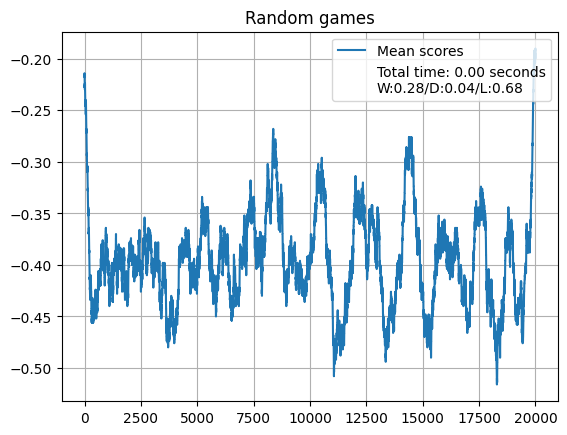

In [19]:
env = gym.make('Blackjack-v1')

input_dims = 3

EPOCHS = 20_000
memory = ReplayMemory([input_dims], mem_size=EPOCHS)
scores = []

for epoch in range(EPOCHS):
  state, _ = env.reset()
  done = False
  mini_memory = []
  score = 0
  while not done:

    # could this be improved?
    action = env.action_space.sample()

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    mini_memory.append((state, action, reward, next_state, done))
    score += reward
    state = next_state

  if score == 1: # if VICTORY
    # if np.random.rand() < .95:
      for mm in mini_memory:
        memory.store_transition(*mm) # keep good examples mostly
  else: # if DRAW or LOSS
    if np.random.rand() < .05:
      for mm in mini_memory:
        memory.store_transition(*mm) # keep some bad examples
  scores.append(score)

stats = print_stats(scores)
plot_learning(scores, 'Random games', 0, stats, window_len=500)

In [20]:
len(memory)

8800

##Train SOM

In [24]:
# Create environment
env = gym.make('Blackjack-v1')

# SOM parameters
som_width = 20
som_height = 20
input_dim = 3
alpha = .1
alpha_dec = .99
alpha_min = 1e-5
sigma = max(som_width, som_height)/2
sigma_dec = .99
sigma_min = 1e-3
som_weights = np.random.rand(som_width, som_height, input_dim+1)
# this +1 is important!!

def init_som_weights(som_weights):
  for i in range(len(som_weights)):
    for j in range(len(som_weights[i])):
      som_weights[i,j] = (np.random.randint(33),\
                          np.random.randint(12),\
                          np.random.randint(2), \
                          np.random.randint(2))

# function to find the BMU
def find_bmu(som_weights, input_vector):
  """ For a given SOM and a state/input vector, find the
  best matching unit OR namely the closest vector based on L2 distance
  and return its index. """
  bmu_idx = None
  min_dist = float('inf')
  som_width = len(som_weights)
  for i in range(som_width):
    som_height = len(som_weights[i])
    for j in range(som_height):
      w = som_weights[i, j]
      dist = np.linalg.norm(input_vector - w)
      if dist < min_dist:
        min_dist = dist
        bmu_idx = (i, j)
  return bmu_idx

# function to update the given SOM weights in place
def update_som(som_weights, input_vector, bmu_idx, alpha, sigma):
  """ This function takes as input the SOM and a state/input vector
  and updates the neighbourhood vectors, pulling them closer to the winning
  vector. """
  som_width = len(som_weights)
  for i in range(som_width):
    som_height = len(som_weights[i])
    for j in range(som_height):
      w = som_weights[i, j]
      dist = np.linalg.norm(np.array([i, j]) - np.array(bmu_idx))
      if dist < sigma:
        # influence is less the farther a vector is in 2D space
        influence = np.exp(-dist**2 / (2 * (sigma**2)))
        som_weights[i, j] += alpha * influence * (input_vector - w)

# good initialization plays a huge part in this!
# init_som_weights(som_weights)

# iterate over all stored memories and train the map
for mem_idx in range(len(memory)):
  state = list(memory.states[mem_idx])
  # normalize state values
  state[0] /= 31 # 31 is the max possible value
  state[1] /= 11 # 11 is the max possible value
  action = [memory.actions[mem_idx]]
  # print(state, action, state+action)
  bmu_idx = find_bmu(som_weights, state+action)
  update_som(som_weights, state+action, bmu_idx, alpha, sigma)
  # decay arguments
  alpha = min(alpha * alpha_dec, alpha_min)
  sigma = min(sigma * sigma_dec, sigma_min)



## Visualise results

In [25]:
ALL_POSSIBLE_OBSERVATIONS = []
for i in range(1,22):
  for j in range(1,12):
    # for k in range(0,2):
      k=0
      ALL_POSSIBLE_OBSERVATIONS.append([i,j,k])
      if i>11:
        ALL_POSSIBLE_OBSERVATIONS.append([i,j,k+1])
ALL_POSSIBLE_OBSERVATIONS = np.array(ALL_POSSIBLE_OBSERVATIONS,dtype=np.int8)
observation_space = ALL_POSSIBLE_OBSERVATIONS

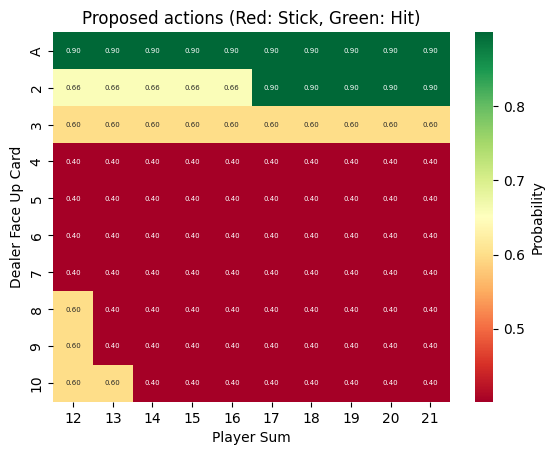

In [26]:
import seaborn as sns
rows, cols = 12, 22
# first four rows are ommitted
policy_grid = np.zeros((rows, cols))

for obs in observation_space:
  obs = list(obs)
  stick_idx = find_bmu(som_weights, obs+[0])
  hit_idx = find_bmu(som_weights, obs+[1])
  stick_prob = som_weights[stick_idx][-1]#[obs][0]
  hit_prob = som_weights[hit_idx][-1]#[obs][1]
  minimum = min(stick_prob, hit_prob)
  maximum = max(stick_prob, hit_prob)
  # print(minimum, maximum)
  # continue
  if hit_prob > stick_prob:
    selected_prob = hit_prob
  else:
    selected_prob = 1-stick_prob
  # stick_prob_norm = (stick_prob - minimum) / (maximum - minimum)
  # hit_prob_norm = (hit_prob - minimum) / (maximum - minimum)

  player_sum = obs[0]
  dealer_card = obs[1]
  # selected_prob = max(stick_prob_norm, hit_prob_norm)
  # selected_prob = max(stick_prob, hit_prob)
  policy_grid[dealer_card, player_sum] = selected_prob


plt.figure(1, dpi=100)
ax = plt.gca()
sns.heatmap(policy_grid[1:11, 12:], cmap='RdYlGn', annot=True, fmt='.2f',
            cbar_kws={'label': 'Probability'}, annot_kws={'size': 5})
plt.title('Proposed actions (Red: Stick, Green: Hit)')
plt.xlabel('Player Sum')

plt.ylabel('Dealer Face Up Card')
plt.xticks(np.arange(1, 11)-.5,range(12,22))
plt.yticks(np.arange(1,11)-.5, ["A"] + list(range(2, 11)))

plt.show();